[讲解视频](https://www.bilibili.com/video/BV1K54y117yD)

In [1]:
%matplotlib inline

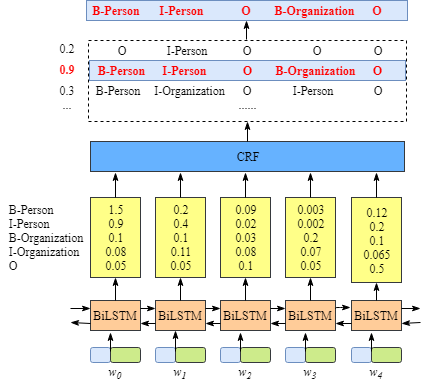

In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [3]:
def argmax(vec):
    # return the argmax as a python int
    # 返回vec的dim为1维度上的最大值的索引
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    # 把句子转化成id
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [4]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size) # 得到发射分数

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter( # 初始化转移矩阵分数 [i,j]:j->i
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000 # 初始化其他tag转移到START_TAG概率非常小
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000 # 初始化STOP_TAG转移到其他tag概率非常小

        self.hidden = self.init_hidden()

    def init_hidden(self):
        # 初始化LSTM参数
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # 通过前向算法递推计算所有可能路径分数总和
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        # 初始化step 0即START的发射分数，START_TAG为0，其余为-10000
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        # 将初始化START位置为0的发射分数赋值给previous
        previous = init_alphas

        # Iterate through the sentence
        # 迭代整个句子
        for obs in feats:
            # 当前时间步的前向tensor
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                # 取出当前tag的发射分数
                emit_score = obs[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                # 取出当前tag的由之前tag转移过来的转移分数
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                # 当前路径得分=之前时间步分数+转移分数+发射分数
                next_tag_var = previous + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                # 对当前分数log-sum-exp
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            # 更新previous递推下一个时间步
            previous = torch.cat(alphas_t).view(1, -1)
        # 考虑最终转移到STOP TAG
        terminal_var = previous + self.transitions[self.tag_to_ix[STOP_TAG]]
        # 计算最终分数
        scores = log_sum_exp(terminal_var)
        return scores

    def _get_lstm_features(self, sentence):
        # 通过biLSTM提取特征
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) # 将句子转化为词向量
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) # 讲过BiLSTM
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out) # 经过全连接层提取特征
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        # 计算给定tag序列的分数
        # feats为发射分数
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags]) # 接上START_TAG
        for i, feat in enumerate(feats):
           # 路径分数 = 发射分数 + 转移分数
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # 初始化viterbi的previous
        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # previous at step i holds the viterbi variables for step i-1
        previous = init_vvars
        for obs in feats:
            # 保留当前时间步的回溯指针
            bptrs_t = []  # holds the backpointers for this step
            # 保留当前时间步的维特比变量
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                # 维特比算法记录最优路径时只考虑上一步的分数以及上一步tag转移到当前tag的转移分数
                # 并不取决当前tag的发射分数
                next_tag_var = previous + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            # 更新previous，加上当前tag的发射分数obs
            previous = (torch.cat(viterbivars_t) + obs).view(1, -1)
            # 回溯指针记录当前时间步各个tag来源前一步的tag
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        # 考虑最终转移到STOP TAG的转移分数
        terminal_var = previous + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        # 通过回溯指针解码出最优路径
        best_path = [best_tag_id]
        # best_tag_id作为线头，反向遍历bptrs_t找到最优路径
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        # 去除START_TAG
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        # CRF损失函数由两部分组成，真实路径的分数和所有路径的总分数
        # 真实路径的分数应该是所有路径中分数最高的
        # log真实路径的分数/log所有可能路径的分数，越大越好，构造crf loss取反，loss越小越好
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        # 通过biLSTM提取发射分数
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        # 根据发射分数以及转移分数，通过viterbi解码找到最优路径
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [5]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5
HIDDEN_DIM = 4

# Make up some training data
training_data = [(
    "the wall street journal reported today that apple corporation made money".split(),
    "B I I I O O O B I O O".split()
), (
    "georgia tech is a university in georgia".split(),
    "B I O O O O B".split()
)]

word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# Check predictions before training
# 训练前检查模型训练结果
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
    print(model(precheck_sent))

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(
        300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        # pytorch梯度累计要清空梯度
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        # 输入转化为tensor
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        # Step 3. Run our forward pass.
        # 进行前向计算取出loss
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        # 计算loss，梯度，通过optimizer更新参数
        loss.backward()
        optimizer.step()

# Check predictions after training
# 训练后查询模型预测结果
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    print(model(precheck_sent))
# We got it!

(tensor(2.6907), [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
(tensor(20.4906), [0, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2])
